# Исследование надежности заемщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.
Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Обзор данных

### First Glance
Загрузим данные и посмотрим, что внутри. 

In [1]:
# Импортируем сразу все, что может понадобиться
import pandas as pd
import seaborn as sns
import math
import numpy as np

df = pd.read_csv('/datasets/data.csv')

In [2]:
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Из необычного пока только дробный отрицательный стаж в днях `days_employed`.

Посмотрим на типы данных и долю пропусков в столбцах.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [4]:
# доля пропусков в процентах
df.isna().mean() * 100

children             0.000000
days_employed       10.099884
dob_years            0.000000
education            0.000000
education_id         0.000000
family_status        0.000000
family_status_id     0.000000
gender               0.000000
income_type          0.000000
debt                 0.000000
total_income        10.099884
purpose              0.000000
dtype: float64

<a id='first_glance'></a>Явные пропуски есть только в столбцах `days_employed` и `total_income`, составляют около 10% и, судя по их количеству, находятся в одних и тех же строках.

Типы данных соответствуют содержимому столбцов. Но для представленных данных хватит и более экономичных подтипов – оптимизируем память после предобработки.

Пройдемся по всем столбцам и посмотрим на распределение значений в них.

### `children` – количество детей в семье

In [5]:
df['children'].value_counts().sort_index()

-1        47
 0     14149
 1      4818
 2      2055
 3       330
 4        41
 5         9
 20       76
Name: children, dtype: int64

В столбце `children` две аномалии: значения `-1` (возможно, неявный пропуск) и `20` (возможно, синоним «<i>больше 5</i>») – вернемся к ним [позже](#children_anomalies). 
>Две трети заемщиков не имеют детей.

### `days_employed` – общий трудовой стаж в днях

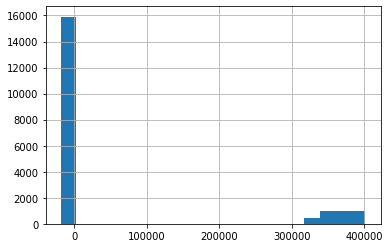

In [6]:
#sns.distplot(a=df['days_employed'], kde=False, bins=50) # alternative method
df['days_employed'].hist(bins=20)

Значения в столбце `days_employed` разделились на две группы: слева от нуля и в районе 300–400 тысяч. Разберемся с этим [позже](#days_employed_anomalies). <br><br>

### `dob_years` – возраст клиента в годах

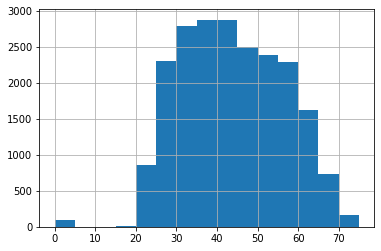

In [7]:
#sns.distplot(a=df['dob_years'], kde=False, bins=15) # alternative method
df['dob_years'].hist(bins=15)

В столбце `dob_years` есть небольшое число нулевых значений (неявных пропусков). 
>Распределение по возрастам адекватное с модой около 40 лет.

### `education_id`, `education` –  уровень образования клиента

In [8]:
#(df.groupby(['education_id', 'education'])
# .agg(count=pd.NamedAgg(column='children', aggfunc='count'))
# .sort_values(by='education_id'))  # alternative method
df.groupby(['education_id', 'education'])['children'].count().sort_index()

education_id  education          
0             ВЫСШЕЕ                   274
              Высшее                   268
              высшее                  4718
1             СРЕДНЕЕ                  772
              Среднее                  711
              среднее                13750
2             НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
              Неоконченное высшее       47
              неоконченное высшее      668
3             НАЧАЛЬНОЕ                 17
              Начальное                 15
              начальное                250
4             УЧЕНАЯ СТЕПЕНЬ             1
              Ученая степень             1
              ученая степень             4
Name: children, dtype: int64

В столбце `education` есть неявные дубли из-за разного регистра написания. При этом `id` в столбце `education_id` проставлен корректно, без учета регистра в написании `education`. Удалим дубли позже. 
>Около 70% заемщиков имеют среднее образование.

### `family_status_id`, `family_status` –  семейное положение

In [9]:
#(df.groupby(['family_status_id', 'family_status'])
# .agg(count=pd.NamedAgg(column='children', aggfunc='count'))
# .sort_values(by='family_status_id')) # alternative method
df.groupby(['family_status_id', 'family_status'])['children'].count().sort_index()

family_status_id  family_status        
0                 женат / замужем          12380
1                 гражданский брак          4177
2                 вдовец / вдова             960
3                 в разводе                 1195
4                 Не женат / не замужем     2813
Name: children, dtype: int64

Со столбцами `family_status_id` и `family_status`, похоже, все в порядке, если не считать единственную прописную букву в последнем статусе.
>Больше половины заемщиков состоят в браке.

### `gender` – пол клиента

In [10]:
df['gender'].value_counts().sort_index()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

Один неявный пропуск в столбце `gender` – значение `XNA`. Разберемся с ним [позже](#gender_anomalies).
>Женщины берут кредиты вдвое чаще, чем мужчины.

### `income_type` – тип занятости

In [11]:
df['income_type'].value_counts().sort_values(ascending=False)

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
студент                1
в декрете              1
Name: income_type, dtype: int64

В столбце `income_type` нет ни дублей, ни пропусков.
>Половина заемщиков – сотрудники.

### `debt` – имел ли задолженность по возврату кредитов

In [12]:
df['debt'].value_counts().sort_index()

0    19784
1     1741
Name: debt, dtype: int64

Столбец `debt` без пропусков.
>Должников около 8%.

### `total_income` – ежемесячный доход

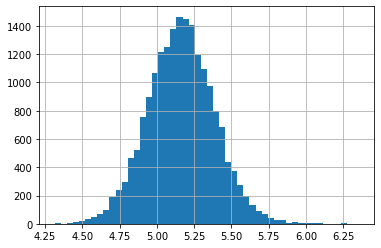

In [13]:
#sns.distplot(a=df['total_income'].fillna(1000000)
#             .apply(math.log10), kde=False, bins=50) # alternative method
df['total_income'].apply(math.log10).hist(bins=50)

In [14]:
print(f"Медианный доход: {df['total_income'].median():.0f}")

Медианный доход: 145018


Распределение доходов из столбца `total_income` удобнее анализировать в логарифмическом масштабе. 
>Не считая пропусков, распределение доходов близко к гауссовому (что не может не радовать) с медианой в 145 тысяч рублей.

### `purpose` – цель получения кредита

In [15]:
#sns.countplot(data=df, y='purpose') # alternative method
df['purpose'].value_counts().sort_index()

автомобили                                478
автомобиль                                495
высшее образование                        453
дополнительное образование                462
жилье                                     647
заняться высшим образованием              496
заняться образованием                     412
на покупку автомобиля                     472
на покупку подержанного автомобиля        479
на покупку своего автомобиля              505
на проведение свадьбы                     777
недвижимость                              634
образование                               447
операции с жильем                         653
операции с коммерческой недвижимостью     651
операции с недвижимостью                  676
операции со своей недвижимостью           630
покупка жилой недвижимости                607
покупка жилья                             647
покупка жилья для сдачи                   653
покупка жилья для семьи                   641
покупка коммерческой недвижимости 

Столбец `purpose` без пропусков, но требует категоризации, т.к. содержит множество сходных целей получения кредита.
>Лидер среди некатегоризированных целей – «свадьба». Горько!

<br><br>

## Предобработка данных

### Проверка данных на аномалии и исправления

#### `children` – количество детей в семье

Вспомним распределение значений в столбце `children`.
<a id='children_anomalies'></a>

In [16]:
# распределение в процентах
df['children'].value_counts().sort_index() / len(df) * 100

-1      0.218351
 0     65.732869
 1     22.383275
 2      9.547038
 3      1.533101
 4      0.190476
 5      0.041812
 20     0.353078
Name: children, dtype: float64

In [17]:
# сумма трех основных групп
df['children'].value_counts().sort_index().loc[0:2].sum() / len(df) * 100

97.66318234610918

Около 98% клиентов имеют от 0 до 2 детей.

Аномальное значение `-1` может означать отсутствие данных или опечатку в значении `1`, а `20` может быть синонимом «<i>больше 5</i>» или опечаткой в значении `2`. Обе аномалии составляют малую долю от любой из трех основных групп клиентов по числу детей.

В «боевых» условиях необходимо было бы обратиться за разъяснениями к владельцу данных. Мы же просто оставим все, как есть. При этом мы не лишимся других данных этих клиентов (по сравнению с вариантом удалить строки целиком) и не внесем искажения в статистику (по сравнению с вариантом заменить аномалии на их предполагаемые правильные значения).

#### `days_employed` – общий трудовой стаж в днях

Взглянем еще раз на данные.
<a id='days_employed_anomalies'></a>

In [18]:
df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


Похоже, что значения в столбце `days_employed` связаны с содержимым столбца `income_type`. Здравый смысл подсказывает также, что `days_employed` должен быть связан с `dob_years`. Посмотрим, как именно. Но сначала временно добавим столбец `years_employed`, в котором рассчитаем количество <i>лет</i> стажа, чтобы было удобнее сравнивать стаж с возрастом.

In [19]:
# делим число дней на среднюю продолжительность григорианского года
df['years_employed'] = df['days_employed'] / 365.2425 

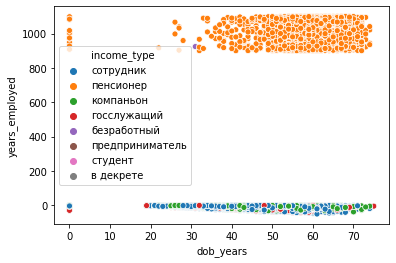

In [20]:
# строим зависимость стажа от возраста клиента
sns.scatterplot(data=df, 
                x='dob_years', 
                y='years_employed', 
                hue='income_type')

In [21]:
# выводим статистику по возрасту и стажу в разрезе типов занятости
(df.groupby('income_type')[['dob_years', 'years_employed']]
 .agg(['count', 'min', 'median', 'max'])
 .sort_values(by=('dob_years', 'count'), ascending=False))

dob_years                years_employed              \
                    count min median max          count         min   
income_type                                                           
сотрудник           11119   0   39.0  74          10014  -50.347235   
компаньон            5085   0   39.0  74           4577  -48.229774   
пенсионер            3856   0   60.0  74           3443  900.028668   
госслужащий          1459   0   40.0  75           1312  -41.597109   
безработный             2  31   38.0  45              2  924.110603   
предприниматель         2  27   42.5  58              1   -1.426034   
в декрете               1  39   39.0  39              1   -9.026222   
студент                 1  22   22.0  22              1   -1.584568   

                                           
                      median          max  
income_type                                
сотрудник          -4.310021    -0.066098  
компаньон          -4.236589    -0.082672  
пенсионер         999.920070  1099.968926  
госслужащий        -7.363240    -0.109391  
безработный      1003.206507  1082.302412  
предприниматель    -1.426034    -1.426034  
в декрете          -9.026222    -9.026222  
студент            -1.584568    -1.584568

Похоже, что для всех типов занятости, кроме `пенсионер` и `безработный`, стаж в днях указан с обратным знаком. Такое могло произойти, если стаж рассчитывался как разница между датой начала трудовой деятельности и датой-временем расчета. Это также объясняет дробность значений в этом столбце (даты могли быть представлены в формате unix time, потом преобразованы в дни делением на 86400).

Проверим реалистичность стажа: вычтем его из возраста клиента и посмотрим на распределение значений результата – приблизительного возраста начала трудовой деятельности – и его зависимость от возраста клиента.

In [22]:
# сохраняем в отдельный датафрейм всех клиентов с ненулевым возрастом,
# кроме пенсионеров и безработных
df_filtered = df[~df['income_type'].isin(['пенсионер', 'безработный']) 
                 & df['dob_years'] != 0] 

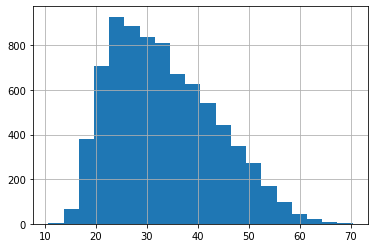

In [23]:
# строим распределение приблизительного возраста начала трудовой деятельности
(df_filtered['dob_years'] + df_filtered['years_employed']).hist(bins=20) 

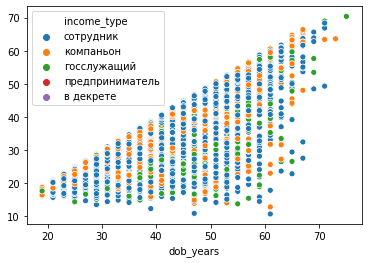

In [24]:
# строим зависимость приблизительного возраста начала трудовой деятельности от возраста клиента
sns.scatterplot(x=df_filtered['dob_years'],
                y=df_filtered['dob_years']+df_filtered['years_employed'], 
                hue=df_filtered['income_type'])

Распределение приблизительного возраста начала трудовой деятельности адекватное с модой около 24 и минимальным значением 10 лет (для возраста клиента 60+, на котором оно достигается, это, наверное, нормально).

Для типов занятости `пенсионер` и `безработный` стаж в днях положительный и нереалистично большой: 900–1100 лет. Возможно, для этих типов стаж указан не в днях, а в часах. Такое возможно, если данные о стаже импортировались, например, из базы данных пенсионного фонда, где этот показатель мог быть рассчитан или просто храниться в часах. Проверим: поделим стаж в годах на 24 и снова посмотрим на распределение приблизительного возраста начала трудовой деятельности и его зависимость от возраста клиента.

In [25]:
# сохраняем в отдельный датафрейм всех пенсионеров и безработных с ненулевым возрастом
df_filtered = df[df['income_type'].isin(['пенсионер', 'безработный']) 
                 & df['dob_years'] != 0] 

In [26]:
# делим стаж на 24
df_filtered.loc[:, 'years_employed'] /= 24

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


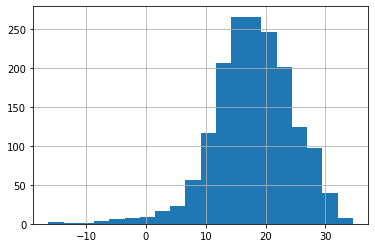

In [27]:
# строим распределение приблизительного возраста начала трудовой деятельности
(df_filtered['dob_years'] - df_filtered['years_employed']).hist(bins=20) 

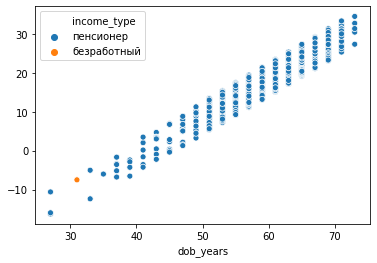

In [28]:
# строим зависимость приблизительного возраста начала трудовой деятельности от возраста клиента
sns.scatterplot(x=df_filtered['dob_years'], 
                y=df_filtered['dob_years']-df_filtered['years_employed'], 
                hue=df_filtered['income_type'])

Гипотеза не подтвердилась: если верить гипотезе, то есть клиенты, которые начали работать до своего рождения.

Настораживает также то, что разброс значений стажа пенсионеров и безработных, в отличие других типов занятости, совсем не зависит от возраста: это фиксированный диапазон, значения в котором распределены равномерно. Очень напоминает равномерное случайное распределение, сгенерированное в диапазоне 900–1100 лет.

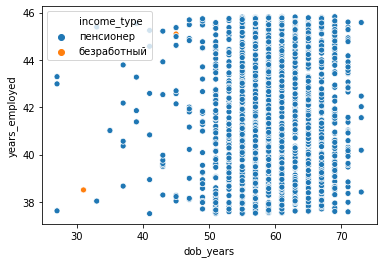

In [29]:
# строим зависимость стажа от возраста клиента
sns.scatterplot(x=df_filtered['dob_years'], 
                y=df_filtered['years_employed'], 
                hue=df_filtered['income_type'])

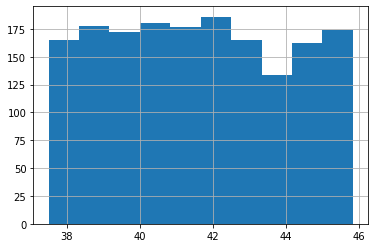

In [30]:
# строим распределение значений стажа
df_filtered['years_employed'].hist()

В «боевых» условиях нужно было бы обратиться за разъяснениями к владельцам данных. Но учитывая, что информация о стаже не потребуется для ответа на вопросы проекта, ограничимся конвертацией часов в дни для пенсионеров и безработных и сменой знака стажа для всех остальных типов занятости, чтобы привести столбец к плюс-минус сопоставимым величинам.

In [31]:
# конвертируем часы в дни для положительных значений days_employed
df.loc[df['days_employed'] > 0, 'days_employed'] /= 24

In [32]:
# проверяем результат
df.loc[df['days_employed'] > 0, 'days_employed']

4        14177.753002
18       16678.380705
24       14106.331371
25       15147.853723
30       13982.569521
             ...     
21505    14121.036100
21508    16104.071420
21509    15090.043922
21518    15583.154618
21521    14330.725172
Name: days_employed, Length: 3445, dtype: float64

In [33]:
# меняем знак у отрицательных days_employed
df.loc[df['days_employed'] < 0, 'days_employed'] *= -1

In [34]:
# удаляем временно созданный столбец years_employed
df = df.drop('years_employed', axis=1)

In [35]:
# проверяем результат
df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,14177.753002,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,14330.725172,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


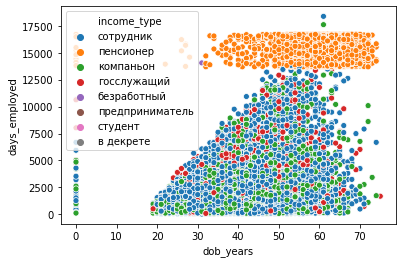

In [36]:
# строим зависимость стажа от возраста клиента
sns.scatterplot(x=df['dob_years'], 
                y=df['days_employed'], 
                hue=df['income_type'])

#### `gender` – пол клиента

Как мы помним, у одного клиента не был указан пол.
<a id='gender_anomalies'></a>

In [37]:
df['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

В этом случае доля аномалии в общем числе записей еще меньше, чем в столбце `children`. По аналогии со столбцом `children` оставим `gender` в покое.

### Заполнение пропусков

Как мы [помним](#first_glance), явные пропуски в исходных данных были только в столбцах `days_employed` и `total_income`. Проверим, что они находятся в одних и тех же строках.

In [38]:
df[df['days_employed'].isna() ^ df['total_income'].isna()]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose


Гипотеза подтвердилась: в данных нет строк, где значение в одном из этих столбцов пусто, а в другом не пусто.

Такие пропуски в данных могли появиться у клиентов, которые не предоставили подтвержденной информации с места работы: трудовой стаж и оклад. Тип занятости `income_type` при этом мог быть записан со слов клиента.

Так как данные об окладе и стаже не нужны для ответа на <i>основные</i> вопросы проекта, мы можем позволить себе заполнить пропуски в них характерными значениями. При этом представляется разумным использовать тип занятости как параметр.

В общем же случае заполнение пропусков характерными значениями не лучшее решение, потому что оно искажает распределение соответствующих величин (повышает плотность характерного значения), что не очень хорошо для моделирования. Менее искажающим решением будет использование стохастической линейной регрессии.

Сохраним строки с пропусками в отдельный датафрейм `df_na` и взглянем на него.

In [39]:
df_na = df[df['days_employed'].isna()]
df_na

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47,Среднее,1,женат / замужем,0,M,компаньон,0,NaN,сделка с автомобилем
21495,1,NaN,50,среднее,1,гражданский брак,1,F,сотрудник,0,NaN,свадьба
21497,0,NaN,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,NaN,строительство недвижимости
21502,1,NaN,42,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,строительство жилой недвижимости


Посмотрим, как клиенты в нем распределены по типу занятости.

In [40]:
df_na['income_type'].value_counts().sort_values(ascending=False)

сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64

Вспомним, как по типу занятости распределены все клиенты.

In [41]:
df['income_type'].value_counts().sort_values(ascending=False)

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
студент                1
в декрете              1
Name: income_type, dtype: int64

Для каждого типа занятости из датафрейма с пропусками найдется хотя бы одно непустое значение из исходного датафрейма – прекрасно.

Сохраним медианы по столбцам `days_employed` и `total_income` в `medians`.

In [42]:
medians = (df.groupby('income_type')[['days_employed', 'total_income']]
           .median().reset_index())
medians

,income_type,days_employed,total_income
0,безработный,15267.235531,131339.751676
1,в декрете,3296.759962,53829.130729
2,госслужащий,2689.368353,150447.935283
3,компаньон,1547.382223,172357.950966
4,пенсионер,15217.221094,118514.486412
5,предприниматель,520.848083,499163.144947
6,сотрудник,1574.202821,142594.396847
7,студент,578.751554,98201.625314


Приджойним медианные значения к `df_na`, сохранив оригинальные индексы.

In [43]:
df_na = (df_na.reset_index().merge(medians, on='income_type', 
                                  how='left', suffixes=('_na', None))
         .set_index('index'))
df_na

,children,days_employed_na,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income_na,purpose,days_employed,total_income
index,,,,,,,,,,,,,,
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу,15217.221094,118514.486412
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование,2689.368353,150447.935283
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости,15217.221094,118514.486412
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем,2689.368353,150447.935283
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу,15217.221094,118514.486412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47,Среднее,1,женат / замужем,0,M,компаньон,0,NaN,сделка с автомобилем,1547.382223,172357.950966
21495,1,NaN,50,среднее,1,гражданский брак,1,F,сотрудник,0,NaN,свадьба,1574.202821,142594.396847
21497,0,NaN,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,NaN,строительство недвижимости,1547.382223,172357.950966


Заполним пропуски в исходном датафрейме медианными значениями из `df_na`.

In [44]:
df[['days_employed','total_income']] = (df[['days_employed','total_income']]
                                        .fillna(df_na[['days_employed','total_income']]))

In [45]:
# alternative method
#df['days_employed'] = df['days_employed'].fillna(df_na['days_employed'])
#df['total_income'] = df['total_income'].fillna(df_na['total_income'])

In [46]:
# alternative method
#df.loc[df['days_employed'].isna(), ['days_employed','total_income']] \
#= df_na[['days_employed','total_income']].values

Проверим результат.

In [47]:
# доля пропусков в процентах
df.isna().mean() * 100 

children            0.0
days_employed       0.0
dob_years           0.0
education           0.0
education_id        0.0
family_status       0.0
family_status_id    0.0
gender              0.0
income_type         0.0
debt                0.0
total_income        0.0
purpose             0.0
dtype: float64

In [48]:
# значения на месте пропущенных
df.loc[df_na.index, ['income_type', 'days_employed', 'total_income']] 

,income_type,days_employed,total_income
index,,,
12,пенсионер,15217.221094,118514.486412
26,госслужащий,2689.368353,150447.935283
29,пенсионер,15217.221094,118514.486412
41,госслужащий,2689.368353,150447.935283
55,пенсионер,15217.221094,118514.486412
...,...,...,...
21489,компаньон,1547.382223,172357.950966
21495,сотрудник,1574.202821,142594.396847
21497,компаньон,1547.382223,172357.950966


Пропуски успешно заменены медианными значениями по соответствующему типу занятости.

### Изменение типов данных

Заменим типы столбцов `days_employed` и `total_income` на int, т.к. знаки после запятой в них вряд ли когда-то кому-то потребуются, а память не резиновая да и, вообще, производительность.

In [49]:
df['days_employed'] = df['days_employed'].astype('int')
df['total_income'] = df['total_income'].astype('int')

In [50]:
df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,14177,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем
21521,0,14330,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем
21522,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость
21523,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля


Посмотрим еще раз на типы данных в столбцах.

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       21525 non-null int64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null int64
purpose             21525 non-null object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


Для всех числовых столбцов теперь используется подтип данных `int64`, для всех строковых – тип `object`. Числа в столбцах не настолько большие, чтобы выделять под каждое 8 байт, а строковые столбцы на самом деле содержат категориальные данные с небольшими словарями. Поэтому для экономии памяти и повышения производительности поменяем типы столбцов на более экономичные.

In [52]:
# даункастим числа до минимально допустимого целого подтипа
df_int = df.select_dtypes(include='int').apply(pd.to_numeric, downcast='signed') 
df_int = df_int.apply(pd.to_numeric, downcast='unsigned') 

In [53]:
# преобразуем строковые столбцы в категориальные
df_object = df.select_dtypes(include='object').apply(pd.DataFrame.astype, 
                                                     dtype='category')

In [54]:
# перезаписываем исходный датафрейм
df[df_int.columns] = df_int
df[df_object.columns] = df_object

In [55]:
# проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int8
days_employed       21525 non-null uint16
dob_years           21525 non-null uint8
education           21525 non-null category
education_id        21525 non-null uint8
family_status       21525 non-null category
family_status_id    21525 non-null uint8
gender              21525 non-null category
income_type         21525 non-null category
debt                21525 non-null uint8
total_income        21525 non-null uint32
purpose             21525 non-null category
dtypes: category(5), int8(1), uint16(1), uint32(1), uint8(4)
memory usage: 339.4 KB


In [56]:
df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,14177,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем
21521,0,14330,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем
21522,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость
21523,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля


Память, занимаемая датафреймом, уменьшилась в 6 раз.

### Удаление дубликатов

#### Явные дубликаты

Проверим, есть ли в данных строки – полные дубликаты.

In [57]:
df.duplicated().sum()

54

Нашлось 54 строки-дубля. Они могли появиться, например, при не совсем корректном (забыли `distinct`) запросе к базе данных, из которой выгружалась информация о клиентах. Удалим их стандартным методом, специально предназначенным для удаления явных дубликатов, не забыв сбросить индекс.

In [58]:
# удаляем
df = df.drop_duplicates().reset_index(drop=True)

In [59]:
# проверяем
df.duplicated().sum()

0

In [60]:
df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,14177,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21466,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем
21467,0,14330,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем
21468,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость
21469,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля


#### Неявные дубликаты

В столбце `education`, как мы помним, есть неявные дубли из-за разного регистра написания. Каждое значение повторяется три раза: все буквы прописные, первая буква прописная, все буквы строчные. При этом `id` в столбце `education_id` проставлен корректно, без учета регистра в написании `education`.

In [61]:
df.groupby(['education_id', 'education'])['children'].count().sort_index()

education_id  education          
0             ВЫСШЕЕ                   273
              Высшее                   268
              высшее                  4710
1             СРЕДНЕЕ                  772
              Среднее                  711
              среднее                13705
2             НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
              Неоконченное высшее       47
              неоконченное высшее      668
3             НАЧАЛЬНОЕ                 17
              Начальное                 15
              начальное                250
4             УЧЕНАЯ СТЕПЕНЬ             1
              Ученая степень             1
              ученая степень             4
Name: children, dtype: int64

Такие «недодубли» могли появиться при объединении информации о клиентах из трех разных источников, у которых тем не менее был синхронизирован `id` в словарях `education`.

Устраним дубликаты, приведя столбец `education` к нижнему регистру специальной строковой функцией.

In [62]:
df['education'] = df['education'].str.lower()

In [63]:
df['education'].value_counts()

среднее                15188
высшее                  5251
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

Вернем столбцу тип `category`.

In [64]:
df['education'] = df['education'].astype('category')

In [65]:
df['education']

0         высшее
1        среднее
2        среднее
3        среднее
4        среднее
          ...   
21466    среднее
21467    среднее
21468    среднее
21469    среднее
21470    среднее
Name: education, Length: 21471, dtype: category
Categories (5, object): [высшее, начальное, неоконченное высшее, среднее, ученая степень]

Посмотрим, как теперь выглядит связка `education_id`–`education`.

In [66]:
df.groupby(['education_id', 'education'])['children'].count().sort_index()

education_id  education          
0             высшее                  5251
1             среднее                15188
2             неоконченное высшее      744
3             начальное                282
4             ученая степень             6
Name: children, dtype: int64

### Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма

Выделим из исходного датафрейма три словаря: `education`, `family_status` и `income_type`. Для этого в новые датафреймы скопируем соответствующие данные из исходного.

In [67]:
education_dict = (df[['education_id', 'education']]
                  .drop_duplicates()
                  .sort_values('education_id')
                  .reset_index(drop=True))

In [68]:
education_dict

,education_id,education
0,0,высшее
1,1,среднее
2,2,неоконченное высшее
3,3,начальное
4,4,ученая степень


In [69]:
family_status_dict = (df[['family_status_id', 'family_status']]
                      .drop_duplicates()
                      .sort_values('family_status_id')
                      .reset_index(drop=True))

In [70]:
family_status_dict

,family_status_id,family_status
0,0,женат / замужем
1,1,гражданский брак
2,2,вдовец / вдова
3,3,в разводе
4,4,Не женат / не замужем


In [71]:
# уникальные значения из столбца income_type
itu = df['income_type'].drop_duplicates()

In [72]:
# создаем словарь для столбца income_type (категорийного типа),
# в котором индекcами будут исходные коды категорий столбца
income_type_dict = pd.DataFrame({'income_type_id': itu.cat.codes.values, 
                                 'income_type': itu.values})
income_type_dict = (income_type_dict
                    .sort_values('income_type_id')
                    .reset_index(drop=True))

In [73]:
income_type_dict

,income_type_id,income_type
0,0,безработный
1,1,в декрете
2,2,госслужащий
3,3,компаньон
4,4,пенсионер
5,5,предприниматель
6,6,сотрудник
7,7,студент


Добавим в исходный датафрейм столбец `income_type_id` и удалим теперь уже лишние `education`, `family_status` и `income_type`. Находившиеся в них текстовые значения можно будет притянуть из соответствующих словарей.

In [74]:
# индексами значений из столбца income_type будут коды их категорий 
df['income_type_id'] = df['income_type'].cat.codes

In [75]:
# удаляем лишние столбцы
df = df.drop(['education', 'family_status', 'income_type'], axis=1)

In [76]:
df

,children,days_employed,dob_years,education_id,family_status_id,gender,debt,total_income,purpose,income_type_id
0,1,8437,42,0,0,F,0,253875,покупка жилья,6
1,1,4024,36,1,0,F,0,112080,приобретение автомобиля,6
2,0,5623,33,1,0,M,0,145885,покупка жилья,6
3,3,4124,32,1,0,M,0,267628,дополнительное образование,6
4,0,14177,53,1,1,F,0,158616,сыграть свадьбу,4
...,...,...,...,...,...,...,...,...,...,...
21466,1,4529,43,1,1,F,0,224791,операции с жильем,3
21467,0,14330,67,1,0,F,0,155999,сделка с автомобилем,4
21468,1,2113,38,1,1,M,1,89672,недвижимость,6
21469,3,3112,38,1,0,M,1,244093,на покупку своего автомобиля,6


### Категоризация дохода

Откатегоризируем доходы клиентов в столбце `total_income_category`, используя специальный метод `cut`.

In [77]:
df['total_income_category'] = pd.cut(df['total_income'], 
                                     [0, 30000, 50000, 200000, 1000000, float('inf')], 
                                     labels=['E', 'D', 'C', 'B', 'A'], 
                                     include_lowest=True)

In [78]:
df

,children,days_employed,dob_years,education_id,family_status_id,gender,debt,total_income,purpose,income_type_id,total_income_category
0,1,8437,42,0,0,F,0,253875,покупка жилья,6,B
1,1,4024,36,1,0,F,0,112080,приобретение автомобиля,6,C
2,0,5623,33,1,0,M,0,145885,покупка жилья,6,C
3,3,4124,32,1,0,M,0,267628,дополнительное образование,6,B
4,0,14177,53,1,1,F,0,158616,сыграть свадьбу,4,C
...,...,...,...,...,...,...,...,...,...,...,...
21466,1,4529,43,1,1,F,0,224791,операции с жильем,3,B
21467,0,14330,67,1,0,F,0,155999,сделка с автомобилем,4,C
21468,1,2113,38,1,1,M,1,89672,недвижимость,6,C
21469,3,3112,38,1,0,M,1,244093,на покупку своего автомобиля,6,B


Новый столбец уже имеет тип `category`. Проверим результат.

In [79]:
(df.groupby('total_income_category')['total_income']
 .agg(['count', 'min', 'median', 'max'])
 .sort_index())

,count,min,median,max
total_income_category,,,,
E,22,20667,26431.0,29749
D,350,30075,43857.5,49996
C,16032,50025,130397.0,199980
B,5042,200001,257685.5,997014
A,25,1004476,1223042.0,2265604


Три четверти клиентов попадают в категорию `С` с доходом от 50001 до 200000.

### Категоризация целей кредита

Для категоризации целей кредита создадим специальную функцию.

In [80]:
def get_purpose_category(purpose):
    if 'свад' in purpose: return 'проведение свадьбы'
    if 'авто' in purpose: return 'операции с автомобилем'
    if 'образ' in purpose: return 'получение образования'
    if 'жил' in purpose: return 'операции с недвижимостью'
    if 'недвиж' in purpose: return 'операции с недвижимостью'

Теперь применим функцию к столбцу `purpose` и сохраним результат в столбце `purpose_category`.

In [81]:
df['purpose_category'] = df['purpose'].apply(get_purpose_category).astype('category')

In [82]:
df

,children,days_employed,dob_years,education_id,family_status_id,gender,debt,total_income,purpose,income_type_id,total_income_category,purpose_category
0,1,8437,42,0,0,F,0,253875,покупка жилья,6,B,операции с недвижимостью
1,1,4024,36,1,0,F,0,112080,приобретение автомобиля,6,C,операции с автомобилем
2,0,5623,33,1,0,M,0,145885,покупка жилья,6,C,операции с недвижимостью
3,3,4124,32,1,0,M,0,267628,дополнительное образование,6,B,получение образования
4,0,14177,53,1,1,F,0,158616,сыграть свадьбу,4,C,проведение свадьбы
...,...,...,...,...,...,...,...,...,...,...,...,...
21466,1,4529,43,1,1,F,0,224791,операции с жильем,3,B,операции с недвижимостью
21467,0,14330,67,1,0,F,0,155999,сделка с автомобилем,4,C,операции с автомобилем
21468,1,2113,38,1,1,M,1,89672,недвижимость,6,C,операции с недвижимостью
21469,3,3112,38,1,0,M,1,244093,на покупку своего автомобиля,6,B,операции с автомобилем


Проверим результат работы функции.

In [83]:
(df[['purpose_category', 'purpose']]
 .drop_duplicates()
 .sort_values(by=['purpose_category', 'purpose']))

,purpose_category,purpose
36,операции с автомобилем,автомобили
49,операции с автомобилем,автомобиль
117,операции с автомобилем,на покупку автомобиля
18,операции с автомобилем,на покупку подержанного автомобиля
19,операции с автомобилем,на покупку своего автомобиля
1,операции с автомобилем,приобретение автомобиля
77,операции с автомобилем,свой автомобиль
78,операции с автомобилем,сделка с автомобилем
41,операции с автомобилем,сделка с подержанным автомобилем
31,операции с недвижимостью,жилье


In [84]:
df['purpose_category'].value_counts().sort_values(ascending=False)

операции с недвижимостью    10814
операции с автомобилем       4308
получение образования        4014
проведение свадьбы           2335
Name: purpose_category, dtype: int64

Половина кредитов приходится на операции с недвижимостью.
<br><br>

## Ответы на вопросы

### Есть ли зависимость между количеством детей и возвратом кредита в срок?

Посмотрим, как от числа детей зависит доля должников.

In [85]:
debt_by_children = (df.groupby('children')
                    .agg(clients=pd.NamedAgg(column='debt', aggfunc='count'),
                         debt_rate=pd.NamedAgg(column='debt', aggfunc='mean')))

In [86]:
debt_by_children

,clients,debt_rate
children,,
-1,47,0.021277
0,14107,0.075353
1,4809,0.092327
2,2052,0.094542
3,330,0.081818
4,41,0.097561
5,9,0.000000
20,76,0.105263


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb3c277290>,
      dtype=object)

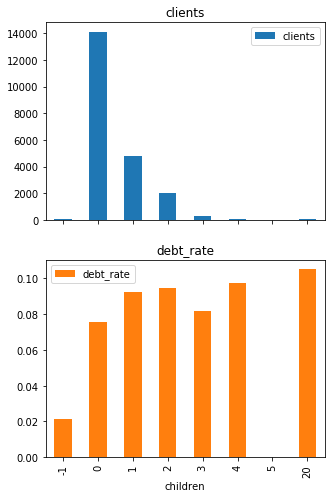

In [87]:
(debt_by_children
 .plot(kind='bar', subplots=True, figsize=(5, 8)))

Группы клиентов с числом детей 0, 1 и 2 навскидку достаточно многочисленны, чтобы доверять значению доли должников в них, составляющей 7,5, 9,2 и 9,5%, соответственно. Остальные группы для этого слишком малочисленны, опять же навскидку. Для строгого анализа необходима оценка статистической значимости доли должников в каждой группе, что, к сожалению, выходит за рамки проекта.

Сравним долю должников в каждой группе клиентов с аналогичной долей в самой многочисленной группе бездетных клиентов.

In [88]:
# считаем абсолютную разницу между долей должников в каждой группе и группе бездетных
debt_by_children['no_children_diff'] = (debt_by_children['debt_rate'] 
                                        - debt_by_children.loc[0, 'debt_rate'])

In [89]:
# считаем относительную разницу между долей должников в каждой группе и группе бездетных
debt_by_children['no_children_ratio'] = (debt_by_children['no_children_diff'] 
                                         / debt_by_children.loc[0, 'debt_rate'])

In [90]:
# выводим результаты для трех основных групп клиентов
debt_by_children.loc[0:2]

,clients,debt_rate,no_children_diff,no_children_ratio
children,,,,
0,14107,0.075353,0.000000,0.000000
1,4809,0.092327,0.016974,0.225264
2,2052,0.094542,0.019189,0.254659


Доля должников среди клиентов с одним ребенком на 1,7 пп. или 23% выше, чем среди бездетных.<br>
Доля должников среди клиентов с двумя детьми на 1,9 пп. или 25% выше, чем среди бездетных.

>Таким образом, наличие одного или двух детей у клиента повышает риск возникновения задолженности примерно на четверть по сравнению со средним клиентом без детей. Для оценки риска возникновения задолженности у клиентов с б<i>о</i>льшим числом детей, скорее всего, не достаточно статистики.

### Есть ли зависимость между семейным положением и возвратом кредита в срок?

Посмотрим, как доля должников зависит от семейного положения.

In [91]:
debt_by_family_status = (df.groupby('family_status_id')
                         .agg(clients=pd.NamedAgg(column='debt', aggfunc='count'),
                              debt_rate=pd.NamedAgg(column='debt', aggfunc='mean'))
                         .merge(family_status_dict, 
                                on='family_status_id', how='left')
                         .set_index('family_status')
                         [['clients', 'debt_rate']])

In [92]:
debt_by_family_status

,clients,debt_rate
family_status,,
женат / замужем,12344,0.075421
гражданский брак,4163,0.093202
вдовец / вдова,959,0.065693
в разводе,1195,0.071130
Не женат / не замужем,2810,0.097509


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb3c1385d0>,
      dtype=object)

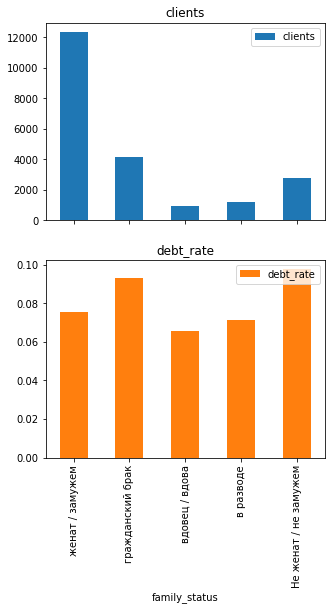

In [93]:
(debt_by_family_status
 .plot(kind='bar', subplots=True, figsize=(5, 8)))

Будем считать, что все группы клиентов по семейному положению достаточно многочисленны, чтобы доверять значению доли должников в них. Опять же, для строгого анализа необходима оценка статистической значимости доли должников в каждой группе, но не в этот раз.

Сравним долю должников в каждой группе клиентов с аналогичной долей в самой многочисленной группе женатых/замужних клиентов.

In [94]:
# считаем абсолютную разницу между долей должников в каждой группе и группе женатых/замужних
debt_by_family_status['married_diff'] \
= debt_by_family_status['debt_rate'] \
- debt_by_family_status.loc['женат / замужем', 'debt_rate']

In [95]:
# считаем относительную разницу между долей должников в каждой группе и группе женатых/замужних
debt_by_family_status['married_ratio'] \
= debt_by_family_status['married_diff'] \
/ debt_by_family_status.loc['женат / замужем', 'debt_rate']

In [96]:
# выводим результаты 
debt_by_family_status

,clients,debt_rate,married_diff,married_ratio
family_status,,,,
женат / замужем,12344,0.075421,0.000000,0.000000
гражданский брак,4163,0.093202,0.017781,0.235753
вдовец / вдова,959,0.065693,-0.009728,-0.128980
в разводе,1195,0.071130,-0.004292,-0.056901
Не женат / не замужем,2810,0.097509,0.022088,0.292857


Доля должников среди неженатых/незамужних клиентов на 2,2 пп. или 29% выше, чем среди женатых/замужних.<br>
Доля должников среди клиентов в гражданском браке на 1,8 пп. или 24% выше, чем среди женатых/замужних.<br>
Доля должников среди клиентов в разводе на 0,4 пп. или 6% ниже, чем среди женатых/замужних.<br>
Доля должников среди овдовевших клиентов на 1,0 пп. или 13% ниже, чем среди женатых/замужних.

>Таким образом, клиенты, состоящие или состоявшие в официальном браке, реже других становятся должниками. Риск возникновения задолженности у неженатых/незамужних клиентов и клиентов, состоящих в гражданском браке, выше, чем у женатых/замужних, на 29 и 24%, соответственно. А у разведенных и овдовевших клиентов этот риск даже ниже, чем у женатых/замужних: на 6 и 13%, соответственно.

### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Посмотрим, как доля должников зависит от уровня дохода клиента.

In [97]:
debt_by_income = (df.groupby('total_income_category')
                  .agg(clients=pd.NamedAgg(column='debt', aggfunc='count'),
                       debt_rate=pd.NamedAgg(column='debt', aggfunc='mean')))

In [98]:
debt_by_income

,clients,debt_rate
total_income_category,,
E,22,0.090909
D,350,0.060000
C,16032,0.084830
B,5042,0.070607
A,25,0.080000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb3c088c10>,
      dtype=object)

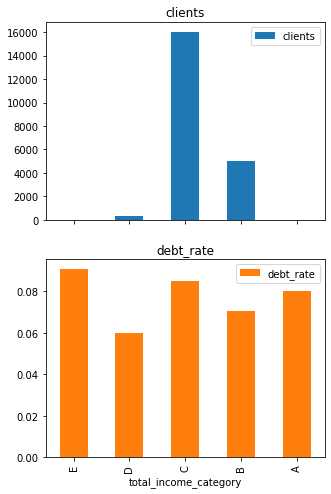

In [99]:
(debt_by_income
 .plot(kind='bar', subplots=True, figsize=(5, 8)))

Мы, по сути, имеем дело с клиентами лишь из двух категорий уровня дохода: В и С с долей должников 7,1 и 8,5%, соответственно. Остальные категории слишком малочисленны, чтобы делать какие-то выводы о доле должников в них. Но, по-прежнему, для строгого анализа необходима оценка статистической значимости доли должников в каждой категории.

Сравним долю должников в каждой категории с аналогичной долей в самой многочисленной категории С.

In [100]:
# считаем абсолютную разницу между долей должников в каждой категории и категории С
debt_by_income['С_diff'] \
= debt_by_income['debt_rate'] \
- debt_by_income.loc['C', 'debt_rate']

In [101]:
# считаем относительную разницу между долей должников в каждой категории и категории С
debt_by_income['С_ratio'] \
= debt_by_income['С_diff'] \
/ debt_by_income.loc['C', 'debt_rate']

In [102]:
# выводим результаты для двух основных категорий
debt_by_income.loc['C':'B']

,clients,debt_rate,С_diff,С_ratio
total_income_category,,,,
C,16032,0.084830,0.000000,0.000000
B,5042,0.070607,-0.014223,-0.167669


Доля должников в категории уровня дохода B на 1,4 пп. или 17% ниже, чем в категории С.

>Таким образом, риск возникновения задолженности среди клиентов с уровнем дохода от 200001 до 1000000 на 17% ниже, чем среди клиентов с уровнем дохода от 50001 до 200000. Для оценки риска возникновения задолженности у клиентов с уровнем дохода ниже 50001 и выше 1000000, скорее всего, не достаточно статистики.

### Как разные цели кредита влияют на его возврат в срок?

Посмотрим, как доля должников зависит от цели кредита.

In [103]:
debt_by_purpose = (df.groupby('purpose_category')
                   .agg(clients=pd.NamedAgg(column='debt', aggfunc='count'),
                        debt_rate=pd.NamedAgg(column='debt', aggfunc='mean')))

In [104]:
debt_by_purpose

,clients,debt_rate
purpose_category,,
операции с автомобилем,4308,0.093547
операции с недвижимостью,10814,0.072314
получение образования,4014,0.092177
проведение свадьбы,2335,0.079657


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb36f43d10>,
      dtype=object)

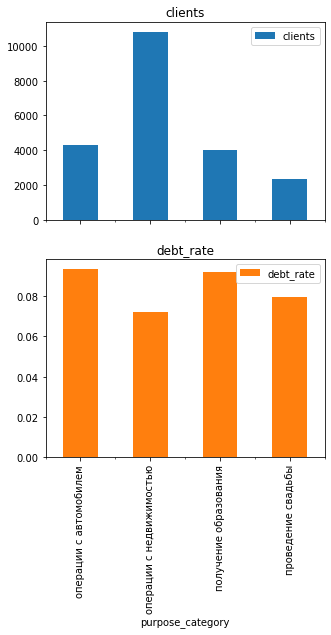

In [105]:
(debt_by_purpose
 .plot(kind='bar', subplots=True, figsize=(5, 8)))

Будем считать, что все группы клиентов по цели кредита достаточно многочисленны, чтобы доверять значению доли должников в них. Тем не менее, как мы помним, для строгого анализа необходима оценка статистической значимости доли должников в каждой группе.

Сравним долю должников в каждой группе с аналогичной долей в самой многочисленной группе – категории целей кредита «операции с недвижимостью».

In [106]:
# считаем абсолютную разницу между долей должников в каждой группе 
# и группе «операции с недвижимостью»
debt_by_purpose['realty_diff'] \
= debt_by_purpose['debt_rate'] \
- debt_by_purpose.loc['операции с недвижимостью', 'debt_rate']

In [107]:
# считаем относительную разницу между долей должников в каждой группе 
# и группе «операции с недвижимостью»
debt_by_purpose['realty_ratio'] \
= debt_by_purpose['realty_diff'] \
/ debt_by_purpose.loc['операции с недвижимостью', 'debt_rate']

In [108]:
# выводим результаты 
debt_by_purpose

,clients,debt_rate,realty_diff,realty_ratio
purpose_category,,,,
операции с автомобилем,4308,0.093547,0.021233,0.293627
операции с недвижимостью,10814,0.072314,0.000000,0.000000
получение образования,4014,0.092177,0.019864,0.274688
проведение свадьбы,2335,0.079657,0.007344,0.101554


Доля должников среди клиентов с автокредитом на 2,1 пп. или 29% выше, чем среди ипотечников.<br>
Доля должников среди клиентов с кредитом на образование на 2,0 пп. или 27% выше, чем среди ипотечников.<br>
Доля должников среди клиентов с кредитом на свадьбу на 0,7 пп. или 10% выше, чем среди ипотечников.

>Таким образом, риск возникновения задолженности выше у клиентов с кредитами на автомобиль (9,4%) или образование (9,2%) и ниже у клиентов с кредитами на недвижимость (7,2%) или свадьбу (8,0%).

## Общий вывод

По имеющимся данным можно сделать следующие выводы.
<ol>
<li>Наличие у клиента одного–двух детей повышает риск возникновения задолженности примерно на четверть по сравнению со клиентом без детей.</li>
<li>Клиенты, не состоявшие в официальном браке, становятся должниками примерно на 25–50% чаще, чем клиенты состоящие или состоявшие в нем.</li>
<li>Риск возникновения задолженности у клиентов с доходом 200–1000k на 17% ниже, чем у клиентов с доходом 50–200k.</li>
<li>Клиенты с кредитами на автомобиль или образование примерно на 15–30% чаще становятся должниками, чем клиенты с кредитами на недвижимость или свадьбу.</li>
</ol>

Для более точного ответа на поставленные вопросы требуется больше данных по менее представленным группам клиентов.